In [1]:
## try adding memory to these agents 

import random 
import numpy as np 
import gym 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from lanczos import l_lanczos, combine_krylov_spaces 

GAMMA = .99 

class Object(object):
    pass

class ReplayBuffer(): 
    def __init__(self, capacity=10000): 
        self.n = 0 
        self.capacity = capacity 
        self.state_list = [] 
        self.action_list = [] 
        self.reward_list = [] 
        self.next_state_list = [] 
        self.done_list = [] 
        pass 
    def __len__(self):
         return self.n 
    def add(self, state, action, reward, next_state, done): 
        if self.n >= self.capacity: 
            ## discard earliest observation 
            self.state_list = self.state_list[1:] 
            self.action_list = self.action_list[1:] 
            self.reward_list = self.reward_list[1:] 
            self.next_state_list = self.next_state_list[1:] 
            self.done_list = self.done_list[1:] 
            self.n -= 1 
        pass 
        ## cast to torch  
        state = torch.tensor(state) 
        action = torch.tensor(action) 
        reward = torch.tensor(reward) 
        next_state = torch.tensor(next_state) 
        done = torch.tensor(done) 
        ## append to buffer 
        self.state_list.append(state) 
        self.action_list.append(action) 
        self.reward_list.append(reward) 
        self.next_state_list.append(next_state) 
        self.done_list.append(done) 
        self.n += 1 
        pass 
    def sample(self, batch_size=32, idx_list=None): 
        ## sample lists 
        out = Object() ## transitions 
        out.state = [] 
        out.action = [] 
        out.reward = [] 
        out.next_state = [] 
        out.done = [] 
        if idx_list is not None: 
            batch_size = len(idx_list) 
        for i in range(batch_size): 
            if idx_list is None: 
                idx = random.randint(0, self.n-1) 
            else: 
                idx = idx_list[i]
                pass 
            out.state.append(self.state_list[idx]) 
            out.action.append(self.action_list[idx]) 
            out.reward.append(self.reward_list[idx]) 
            out.next_state.append(self.next_state_list[idx]) 
            out.done.append(self.done_list[idx]) 
            pass 
        ## stack  
        out.state = torch.stack(out.state) 
        out.action = torch.stack(out.action) 
        out.reward = torch.stack(out.reward).reshape([-1,1]) 
        out.next_state = torch.stack(out.next_state) 
        out.done = torch.stack(out.done).reshape([-1,1]) 
        return out 
    def clear(self, n=None): 
        'clears first `n` transitions, or all if `n is None`'
        if n is None: 
            n = self.n 
            pass 
        self.state_list = self.state_list[n:] 
        self.action_list = self.action_list[n:] 
        self.reward_list = self.reward_list[n:] 
        self.next_state_list = self.next_state_list[n:] 
        self.done_list = self.done_list[n:] 
        self.n = len(self.state_list) 
        pass 
    pass 

# Define the actor and critic networks 
class SSRAgent(nn.Module): 
    def __init__(self, replay_buffer, ssr_rank=2): 
        super(SSRAgent, self).__init__() 
        self.ssr_rank = ssr_rank 
        self.ssr_low_rank_matrix = None ## =: A 
        self.ssr_residual_diagonal = None ## =: resid 
        self.ssr_center = None 
        self.ssr_prev_center = None 
        self.ssr_n = None 
        ## N * Fisher Information \approx AA^T + resid 
        self.ssr_model_dimension = None 
        self.replay_buffer = replay_buffer 
        pass 
    def loss(self, transitions): 
        raise NotImplementedError('ERROR: loss not implemented!') 
    def memorize(self, n=None): 
        'memorize oldest `n` transitions, or all if `n is None`' 
        self.ssr_prev_center = self.ssr_center 
        self.ssr_center = self.__get_param() ## elliptical centroid 
        if self.ssr_model_dimension is None: 
            self.ssr_model_dimension = self.ssr_center.shape[0] 
            pass 
        ssr_low_rank_matrix, ssr_residual_diagonal = l_lanczos(self.__get_get_grad_generator(n), self.ssr_rank, self.ssr_model_dimension, calc_diag=True) 
        if self.ssr_low_rank_matrix is None: 
            ## first memorization 
            self.ssr_low_rank_matrix = ssr_low_rank_matrix 
            self.ssr_residual_diagonal = ssr_residual_diagonal 
            self.ssr_n = n 
        else: 
            ## combine with previous memories 
            self.ssr_low_rank_matrix = combine_krylov_spaces(self.ssr_low_rank_matrix, ssr_low_rank_matrix) 
            self.ssr_residual_diagonal += ssr_residual_diagonal 
            self.ssr_n += n 
            pass 
        pass 
    def ssr(self, lmbda=None): 
        '''Get the ssr regularizer. If `lmbda is None`, `lmbda` will be set to 1 when `self.ssr_prev_center is None`, 
        otherwise `lmbda` will be the approximately optimal `n_A` value.'''
        if self.ssr_low_rank_matrix is None: 
            return 0. 
        if lmbda is None: 
            lmbda = 1. 
            pass 
        p = self.__get_param() 
        p0 = self.ssr_center 
        d = p - p0 
        A = self.ssr_low_rank_matrix 
        res = self.ssr_residual_diagonal 
        dTA = d.transpose(0,1).matmul(A) 
        ATd = dTA.transpose(0,1) 
        dTresd = (d.transpose(0,1) * res).matmul(d) 
        ssr_sum = dTA.matmul(ATd) + dTresd 
        if lmbda is None: 
            if self.ssr_prev_center is None: 
                lmbda = 1. 
            else: 
                ## approximately optimal lambda 
                dt = p0 - self.ssr_prev_center 
                dtTA = dt.transpose(0,1).matmul(A) 
                ATdt = dtTA.transpose(0,1) 
                dtTresdt = (dt.transpose(0,1) * res).matmul(dt) 
                lmbda = dtTA.matmul(ATdt) + dtTresdt 
                pass 
            pass 
        ## no average, because we're using the log lik  
        ## also, `ssr_n` becomes vague as we iteratively apply optimal lambda 
        return lmbda * .5 * ssr_sum 
    def __get_param(self): 
        return torch.cat([p.reshape([-1, 1]) for p in self.parameters()], dim=0) 
    def __get_get_grad_generator(self, n=None): 
        ## The double get hides `self` in a function context,  
        ## packaging `get_grad_generator` for calling without 
        ## the SSRAgent instance.  
        if n is None: 
            n = self.replay_buffer.n 
            pass 
        def get_grad_generator(): 
            'l-Lanczos alg uses grad at least `ssr_rank` times' 
            def grad_generator(): 
                self.eval() 
                for idx in range(n): 
                    transition = self.replay_buffer.sample(idx_list=[idx]) 
                    loss = self.loss(transition) 
                    loss.backward() 
                    grad_vec = torch.cat([p.grad.reshape([-1]) for p in self.parameters()]) 
                    yield grad_vec 
                    pass
                pass 
            return grad_generator 
        return get_grad_generator 
    pass 

class Actor(SSRAgent):
    def __init__(self, state_dim, action_dim, critic=None, replay_buffer=None, ssr_rank=2): 
        super(Actor, self).__init__(replay_buffer=replay_buffer, ssr_rank=ssr_rank) 
        self.fc1 = nn.Linear(state_dim, 256) 
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, action_dim) 
        self.buffer = Object() 
        self.buffer.critic = critic ## buffer stops param sharing (ie. in `state_dict`)
        pass 
    def forward(self, state): 
        x = torch.relu(self.fc1(state)) 
        x = torch.relu(self.fc2(x)) 
        action = torch.tanh(self.fc3(x)) 
        return action
    def loss(self, transitions): 
        if self.buffer.critic is None: 
            raise ValueError('ERROR: this model has no associated critic!') 
        return -torch.sum(self.buffer.critic(transitions.state, self(transitions.state))) ## log lik, not average log lik 
    pass 

class Critic(SSRAgent):
    def __init__(self, state_dim, action_dim, target_actor=None, target_critic=None, replay_buffer=None, ssr_rank=2): 
        super(Critic, self).__init__(replay_buffer=replay_buffer, ssr_rank=ssr_rank) 
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.buffer = Object() 
        self.buffer.target_actor = target_actor 
        self.buffer.target_critic = target_critic 
        pass 
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value
    def loss(self, transitions): 
        if self.buffer.target_actor is None or self.buffer.target_critic is None: 
            raise ValueError('ERROR: target model missing!') 
        # Calculate the target Q-values
        target_Q = self.buffer.target_critic(transitions.next_state, self.buffer.target_actor(transitions.next_state))
        target_Q = (1 - transitions.done.int()) * target_Q.clone().detach() * GAMMA + transitions.reward 
        # Calculate the current Q-values
        current_Q = self(transitions.state, transitions.action) 
        # Calculate the critic loss
        return torch.sum((target_Q - current_Q).pow(2)) ## log lik, not average log lik 
    pass 

# Create the replay buffer 
replay_buffer = ReplayBuffer(capacity=100000) 

# Create the actor and critic networks
target_critic = Critic(state_dim=4, action_dim=1) 
target_actor = Actor(state_dim=4, action_dim=1) 
critic = Critic(state_dim=4, action_dim=1, target_critic=target_critic, target_actor=target_actor, replay_buffer=replay_buffer) 
actor = Actor(state_dim=4, action_dim=1, critic=critic, replay_buffer=replay_buffer) 

# Define the optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# Define the environment 
env = gym.make('CartPole-v1') 

reward_list = [] 
p_list = [] # DEBUG 
LAMBDA = None 

# Train the agent
for episode in range(1000):
    state = env.reset()
    target_actor.load_state_dict(actor.state_dict()) 
    target_critic.load_state_dict(critic.state_dict()) 

    for t in range(1000): 
        action = actor(torch.tensor(state)) 
        if np.random.binomial(1, max(0,50-episode)/50) > 0: 
            ## random action 
            action = torch.tensor(np.random.uniform(low=-1., high=1.)).reshape([1]) 
            pass 
        
        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1 
        next_state, reward, done, _ = env.step(action_int) 

        replay_buffer.add(state, action, reward, next_state, done) 

        if len(replay_buffer) > 1000: 
            # Sample a batch of transitions from the replay buffer 
            transitions = replay_buffer.sample(batch_size=256) 

            # Calculate the critic loss 
            critic_loss = critic.loss(transitions) + critic.ssr(LAMBDA) 

            # Update the critic network 
            critic_optimizer.zero_grad() 
            critic_loss.backward() 
            critic_optimizer.step() 
            
            # Calculate the actor loss 
            actor_loss = actor.loss(transitions) + actor.ssr(LAMBDA) 

            # Update the actor network 
            actor_optimizer.zero_grad() 
            actor_loss.backward() 
            actor_optimizer.step() 

            if len(replay_buffer) > 2000: 
                ## memorize every 1000 transitions 
                actor.memorize(1000) 
                critic.memorize(1000) 
                replay_buffer.clear(1000) 
                pass 
            pass 

        state = next_state 

        if done:
            break

    # Evaluate the agent
    episode_reward = 0 
    state = env.reset() 

    for t in range(1000): 
        action = actor(torch.tensor(state))

        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) 
        next_state, reward, done, _ = env.step(action_int) 
        p_list.append(action.item()) # DEBUG 

        episode_reward += reward
        state = next_state 

        if done:
            break
    
    reward_list.append(episode_reward)
    print(f'Episode {episode}: {episode_reward}, len(replay_buffer): {len(replay_buffer)}')

/tmp/ipykernel_4719/2985502513.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/astroid/node_classes.py:94: DeprecationWarning: The 'astroid.node_cla

Episode 0: 17.0, len(replay_buffer): 31
Episode 1: 27.0, len(replay_buffer): 51
Episode 2: 13.0, len(replay_buffer): 67
Episode 3: 19.0, len(replay_buffer): 119
Episode 4: 13.0, len(replay_buffer): 129
Episode 5: 12.0, len(replay_buffer): 139
Episode 6: 22.0, len(replay_buffer): 200
Episode 7: 32.0, len(replay_buffer): 230
Episode 8: 20.0, len(replay_buffer): 254
Episode 9: 27.0, len(replay_buffer): 264
Episode 10: 14.0, len(replay_buffer): 278
Episode 11: 10.0, len(replay_buffer): 298
Episode 12: 14.0, len(replay_buffer): 329
Episode 13: 14.0, len(replay_buffer): 354
Episode 14: 29.0, len(replay_buffer): 370
Episode 15: 13.0, len(replay_buffer): 385
Episode 16: 22.0, len(replay_buffer): 402
Episode 17: 15.0, len(replay_buffer): 437
Episode 18: 10.0, len(replay_buffer): 455
Episode 19: 23.0, len(replay_buffer): 521
Episode 20: 11.0, len(replay_buffer): 545
Episode 21: 27.0, len(replay_buffer): 557
Episode 22: 18.0, len(replay_buffer): 569
Episode 23: 13.0, len(replay_buffer): 579
Episo

KeyboardInterrupt: 

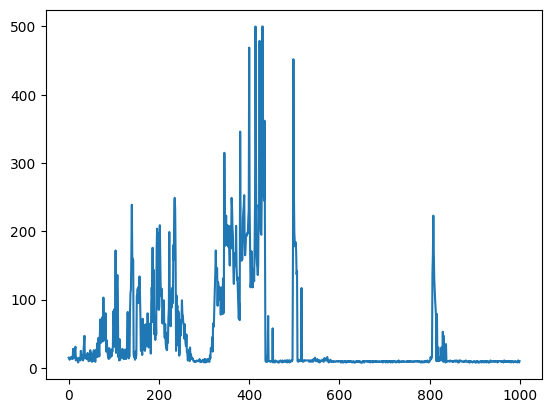

In [2]:
import matplotlib.pyplot as plt


plt.plot(reward_list)
plt.show()

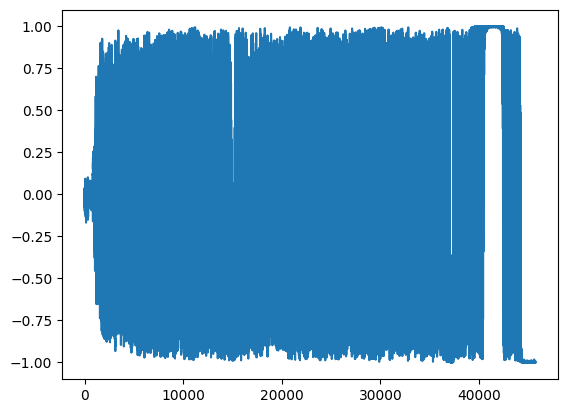

In [3]:
import matplotlib.pyplot as plt


plt.plot(p_list)
plt.show()

In [4]:
x = replay_buffer.sample(3)
print(x.state.shape)
print(x.action.shape)
print(x.reward.shape)
print(x.next_state.shape)
print(x.done.shape)

torch.Size([3, 4])
torch.Size([3, 1])
torch.Size([3, 1])
torch.Size([3, 4])
torch.Size([3, 1])


In [6]:
x = replay_buffer.sample(idx_list=[2,4,5,1])
print(x.state.shape)
print(x.action.shape)
print(x.reward.shape)
print(x.next_state.shape)
print(x.done.shape)

torch.Size([4, 4])
torch.Size([4, 1])
torch.Size([4, 1])
torch.Size([4, 4])
torch.Size([4, 1])
